In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/IS4242 Group 1

Mounted at /content/drive
/content/drive/MyDrive/IS4242 Group 1


In [3]:
os.chdir("/content/drive/MyDrive/IS4242 Group 1")

### Load the dataset

In [4]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(16,12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images/2+0.5,nrow=16).permute(1,2,0)) # images/2+0.5 to unnormalize images
    print(labels)
    break

In [5]:
# Define transforms
valid_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [42]:
BATCH_SIZE = 32 
# Load the dataset
path_train = "./codes/data/seven_classes/augmented"
train_dataset = ImageFolder(root=path_train, transform=train_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

path_val = './codes/data/seven_classes/val'
valid_dataset = ImageFolder(root=path_val, transform=valid_transform)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [43]:
class_names = list(train_dataset.class_to_idx.keys())
train_dataset.class_to_idx

{'Apple': 0,
 'Banana': 1,
 'Capsicum': 2,
 'Lemon': 3,
 'Orange': 4,
 'Pear': 5,
 'Tomato': 6}

tensor([1, 6, 6, 0, 6, 4, 6, 3, 5, 0, 5, 2, 5, 2, 6, 0, 6, 6, 2, 6, 1, 2, 4, 3,
        4, 3, 2, 5, 2, 2, 2, 5])


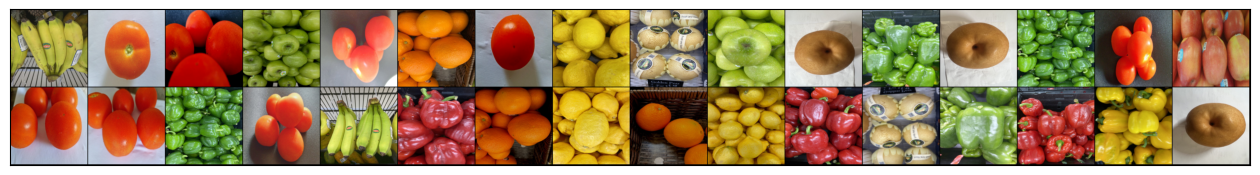

In [45]:
show_batch(train_loader)

tensor([2, 5, 6, 6, 1, 1, 3, 4, 4, 6, 0, 1, 3, 1, 0, 0, 3, 6, 4, 5, 5, 3, 2, 1,
        4, 6, 4, 0, 5, 3, 2, 2])


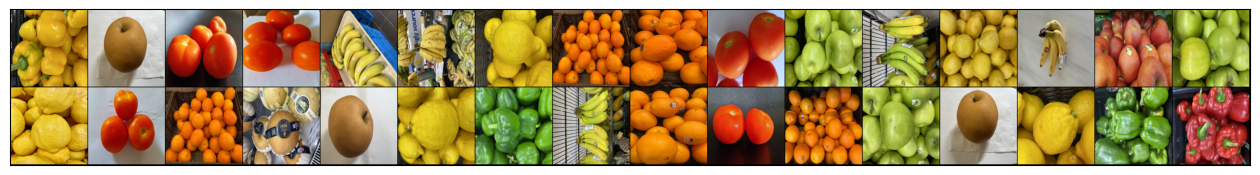

In [46]:
show_batch(valid_loader)

### AlexNet Class

In [10]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super(AlexNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2))
    self.layer3 = nn.Sequential(
        nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU())
    self.layer4 = nn.Sequential(
        nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU())
    self.layer5 = nn.Sequential(
        nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 2))
    self.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(6400, 4096),
        nn.ReLU())
    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU())
    self.fc2= nn.Sequential(
        nn.Linear(4096, num_classes))
      
  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = self.layer5(out)
      out = out.reshape(out.size(0), -1)
      out = self.fc(out)
      out = self.fc1(out)
      out = self.fc2(out)
      return out

In [11]:
class EarlyStopping:
  def __init__(self, tolerance=1, min_delta=0):
    self.tolerance = tolerance
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf
  
  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.tolerance:
        return True
      return False

In [12]:
def start_train_model(model, device, train_loader, valid_loader, optimizer, criterion, epoch, num_epochs):
  train_losses = []
  val_losses = []
  
  for batch_idx, (images, labels) in enumerate(train_loader):  
    # Move tensors to the configured device
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  print('Epoch [{}/{}]\nTrain Loss: {:.4f}'.format(epoch+1, num_epochs, np.mean(train_losses)))
          
  # Validation
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      loss_val = criterion(outputs, labels)
      val_losses.append(loss_val.item())
      del images, labels, outputs

    print('Val loss: {:.4f}\tAcc on {} val images: {:.4f}%\n'.format(np.mean(val_losses), len(valid_loader.dataset), 100 * (correct / total)))
  
  return np.mean(train_losses), np.mean(val_losses)

In [13]:
def start_test_model(model, device, test_loader):
  model.eval()
  total = 0
  correct = 0
  labels_output = []
  predicted_output = []
  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      # Calculate outputs of images by running through the model
      outputs = model(images)
      # Class with highest probability is chosen as prediction
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      labels_output.extend(labels.tolist())
      predicted_output.extend(predicted.tolist())
    print("Accuracy of the network on the {} images: {:.4f}%".format(len(test_loader.dataset), 100 * (correct / total)))
    return labels_output, predicted_output

### Hyperparameters

In [47]:
NUM_CLASSES = len(list(train_dataset.class_to_idx.values()))
EPOCHS = 10
LEARNING_RATE = 0.001 #0.005

model = AlexNet(NUM_CLASSES).to(DEVICE)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay = 0.0005, momentum = 0.9) #weight_decay = 0.005

### Model training

In [48]:
# Train the model
train_loss_list = []
val_loss_list = []
early_stopping = EarlyStopping(tolerance=1, min_delta=0.1)
for epoch in range(EPOCHS):
  train_loss, val_loss = start_train_model(model, DEVICE, train_loader, valid_loader, optimizer, criterion, epoch, EPOCHS)
  train_loss_list.append(train_loss)
  val_loss_list.append(val_loss)
  if early_stopping.early_stop(val_loss):
    print("We are at epoch: ", epoch+1)
    break

Epoch [1/10]
Train Loss: 1.8225
Val loss: 1.6141	Acc on 35 val images: 57.1429%

Epoch [2/10]
Train Loss: 1.2264
Val loss: 1.0448	Acc on 35 val images: 77.1429%

Epoch [3/10]
Train Loss: 0.6656
Val loss: 0.8086	Acc on 35 val images: 80.0000%

Epoch [4/10]
Train Loss: 0.3633
Val loss: 0.9975	Acc on 35 val images: 80.0000%

We are at epoch:  4


In [49]:
y_labels, y_pred = start_test_model(model, DEVICE, train_loader)
cmat = confusion_matrix(y_labels, y_pred)
accuracy_per_class = (cmat.diagonal()/cmat.sum(axis=1)).tolist()
for class_ in range(len(accuracy_per_class)):
  print("Accuracy of class {}: {:.4f} %".format(class_names[class_], accuracy_per_class[class_]))
print(classification_report(y_labels, y_pred))

Accuracy of the network on the 700 images: 93.2857%
Accuracy of class Apple: 0.9600 %
Accuracy of class Banana: 0.9700 %
Accuracy of class Capsicum: 0.6100 %
Accuracy of class Lemon: 1.0000 %
Accuracy of class Orange: 1.0000 %
Accuracy of class Pear: 0.9900 %
Accuracy of class Tomato: 1.0000 %
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       100
           1       1.00      0.97      0.98       100
           2       1.00      0.61      0.76       100
           3       0.75      1.00      0.85       100
           4       0.99      1.00      1.00       100
           5       0.98      0.99      0.99       100
           6       0.97      1.00      0.99       100

    accuracy                           0.93       700
   macro avg       0.95      0.93      0.93       700
weighted avg       0.95      0.93      0.93       700



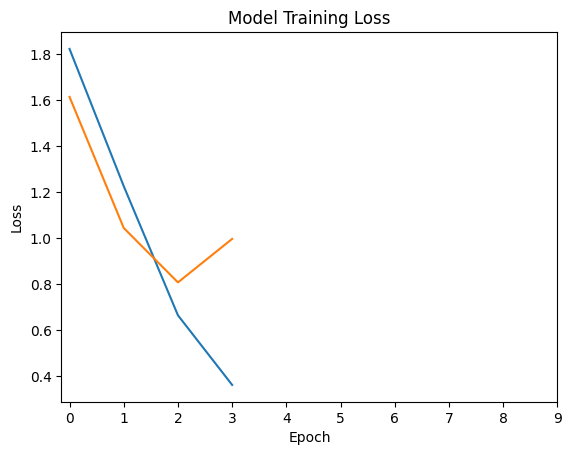

In [50]:
plt.figure()
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.xticks(np.arange(0,EPOCHS,1))
plt.title("Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Testing

In [51]:
y_labels, y_pred = start_test_model(model, DEVICE, valid_loader)
cmat = confusion_matrix(y_labels, y_pred)
accuracy_per_class = (cmat.diagonal()/cmat.sum(axis=1)).tolist()
for class_ in range(len(accuracy_per_class)):
  print("Accuracy of class {}: {:.4f} %".format(class_names[class_], accuracy_per_class[class_]))
print(classification_report(y_labels, y_pred))

Accuracy of the network on the 35 images: 91.4286%
Accuracy of class Apple: 1.0000 %
Accuracy of class Banana: 0.8000 %
Accuracy of class Capsicum: 0.6000 %
Accuracy of class Lemon: 1.0000 %
Accuracy of class Orange: 1.0000 %
Accuracy of class Pear: 1.0000 %
Accuracy of class Tomato: 1.0000 %
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       1.00      0.60      0.75         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         5

    accuracy                           0.91        35
   macro avg       0.93      0.91      0.91        35
weighted avg       0.93      0.91      0.91        35



### Run Prediction

In [19]:
from PIL import Image 

@torch.no_grad()
def prediction(img_path, model, classes, device):
  image_transforms = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
  ])
  image = Image.open(img_path)
  display(image.resize((int(image.size[0]/8),int(image.size[1]/8)), 0))
  image_tensor = image_transforms(image).unsqueeze(0)
  image_tensor = image_tensor.to(device, torch.float)
  output = model(image_tensor)
  index = output.cpu().data.numpy().argmax()
  pred = classes[index]
  return pred

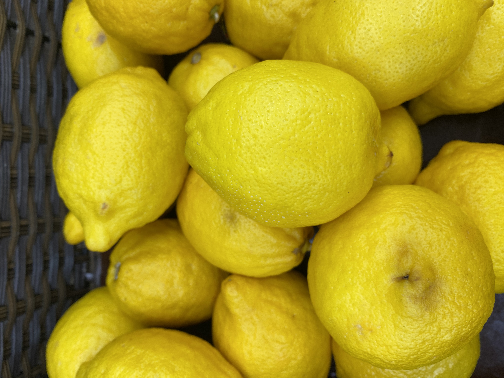

'Lemon'

In [20]:
prediction("./codes/data/lemon_test.jpeg", model, class_names, DEVICE)

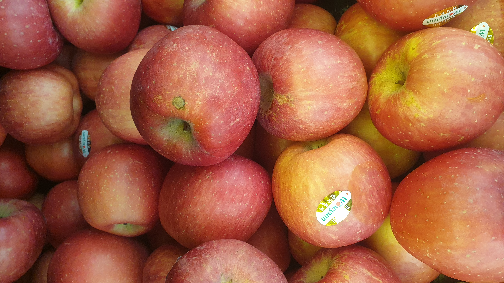

'Apple_Red'

In [21]:
prediction("./codes/data/apple_red_test.jpg", model, class_names, DEVICE)

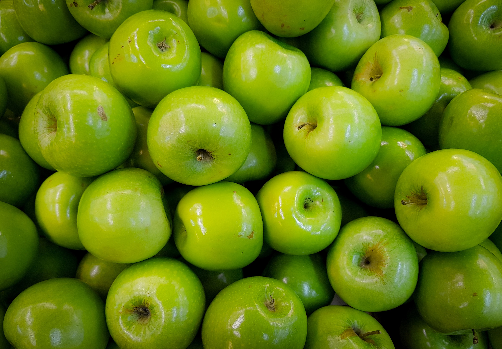

'Apple_Green'

In [22]:
prediction("./codes/data/apple_green_test.jpg", model, class_names, DEVICE)

Save Model

In [23]:
#PATH = "./codes/weights/AlexNetModelFinal.pth"
#torch.save(model.state_dict(), PATH)